# Counting - LSTMs vs GRUs

Welcome to a demonstration of the results presented in the paper "On the Practical Computational Power of Finite-Precision RNNs for Language Recognition" (ACL 2018), available at: https://arxiv.org/abs/1805.04908 

Here we will load some GRU and LSTM networks pre-trained on the context-free and context-sensitive (respectively) grammars $a^nb^n$ and $a^nb^nc^n$, and plot their activations on $a^{1000}b^{1000}$ and $a^{100}b^{100}c^{100}$ (again respectively). These networks are trained by positive examples only (token-predicting networks). 

You can also define and train any other grammar you like, and observe its activations.

In [ ]:
from LSTM import LSTMNetwork
from GRU import GRUNetwork
from RNNTokenPredictor import RNNTokenPredictor
from Helper_Functions import compare_network_to_classifier
import numpy as np
import matplotlib.pyplot as plt
import dynet as dy

In [2]:
def anbn(w):
    return ("ba" not in w) and ("c" not in w) and (w.count("a")==w.count("b"))

def anbncn(w):
    return  ("ac" not in w) and \
            ("ba" not in w) and \
            ("ca" not in w) and \
            ("cb" not in w) and \
            (w.count("a")==w.count("b")) and \
            (w.count("a")==w.count("c"))

In [3]:
anbn_n = 100
anbncn_n = 50

anbnwords = ["a"*i+"b"*i for i in range(anbn_n)]
anbncnwords = ["a"*i+"b"*i+"c"*i for i in range(anbncn_n)]

The following cell is relevant if you wish to train your own language. 
It has a full example use that you can modify for your own language

In [4]:
# simple function for training your own network if you like
def train_network_on_positive_words(rnn,
                                    words,
                                    min_epochs=1000,
                                    max_epochs=2000,
                                    epochs_at_a_time=100,
                                    learning_rate=0.001):
    accuracy = 0
    total_epochs = 0
    while (accuracy < 1 or total_epochs < min_epochs) and (total_epochs <max_epochs):
        rnn.train_group(words,epochs_at_a_time,show=True,loss_every=20,
                       learning_rate=learning_rate, print_time=False)
        total_epochs += epochs_at_a_time
        accuracy = compare_network_to_classifier(rnn, classifier, words)
        digits=pow(10,3)
        print("\t\tcurrent accuracy: [[",int(100*digits*accuracy)/digits," %]]")
        
# example use:
# rnn = RNNTokenPredictor(your_alphabet)
# #     has optional parameters: 
# #     num_layers, hidden_dim, input_dim, 
# #     RNNClass (default LSTMNetwork, can also be GRUNetwork),
# #     reject_threshold
# words = ["a"*n+"b"*n for n in range(100)] #positive examples for anbn language
# train_network_on_positive_words(rnn,words) 
# #      has optional parameters as seen in function definition at top of this cell

In [14]:
#functions for displaying cell activations of networks on a word 

def getcvals(s):
    return np.concatenate([c.npvalue() for c in s.cs])

def gethvals(s):
    return np.concatenate([h.npvalue() for h in s.hs])

def plot_vals_on_word(rnn,w):
    vals_function=getcvals if isinstance(rnn.rnn,LSTMNetwork) else gethvals
    s = rnn.rnn.initial_state
    allvals = [vals_function(s)]
    for c in w:
        s = rnn._next_state(s,c)
        allvals.append(vals_function(s))

    for i in range(len(allvals[0])):
        plt.plot(range(len(allvals)),[vals[i] for vals in allvals])
        pass
    plt.show()
    
def plot_and_classify(rnn,w,truth,title=None):
    print("======================================")
    if not None == title:
        print(title)
        print("======================================")
    print("network classification:",rnn.classify_word(w),"\ntrue classification:",truth(w))
    plot_vals_on_word(rnn,w)


In [12]:
# load our saved LSTM and GRU anbn/anbncn networks


networks = {"anbn":{},"anbncn":{}}
for lang in ["anbn","anbncn"]:
    for arch in ["LSTM","GRU"]:
        networks[lang][arch]=dy.load("old_trained_rnns/"+lang+"_"+arch,
                                     dy.ParameterCollection())[0]

anbn LSTM on sample with n = 1000
network classification: True 
true classification: True


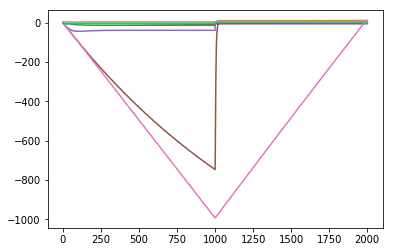

anbn GRU on sample with n = 1000
network classification: True 
true classification: True


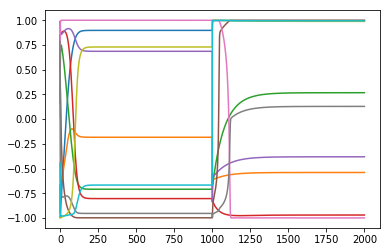

anbncn LSTM on sample with n = 100
network classification: True 
true classification: True


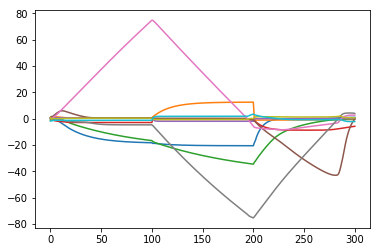

anbncn GRU on sample with n = 100
network classification: True 
true classification: True


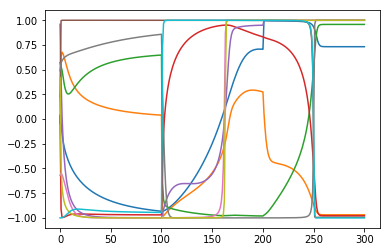

In [20]:
# plot activations for a^1000b^1000, a^100b^100c^100

anbn_n = 1000
anbncn_n = 100
anbn_test = "a"*anbn_n+"b"*anbn_n
anbncn_test = "a"*anbncn_n+"b"*anbncn_n+"c"*anbncn_n

for lang,word,classifier in zip(["anbn","anbncn"],[anbn_test,anbncn_test],[anbn,anbncn]):
    for arch in ["LSTM","GRU"]:
        rnn = networks[lang][arch]
        rnn.renew()
        plot_and_classify(rnn,word,classifier,title=lang+" "+arch+" on sample with n = "+str(word.count("a")))